In [1]:
# Imports

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
plt.style.use('ggplot')

from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC

OMP: Info #274: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/home/rushali/anaconda3/envs/tigra/lib/python3.8/site-packages/tigramite-4.2.2.1-py3.8-linux-x86_64.egg/tigramite/independence_tests/gpdc_torch.py:18: UserWarning: No module named 'torch'
  warnings.warn(str(e))


In [2]:
file = pd.read_csv('/home/rushali/ml703_timeSeriesCausalDiscovery/data/final_data_msft.csv')

In [3]:
file2 = pd.read_csv('/home/rushali/ml703_timeSeriesCausalDiscovery/data/final_data_amzn.csv')

In [4]:
data = file[['day_date','lag_log_close_value','log_num_tweets']]

In [5]:
data2 = file2[['day_date','lag_log_close_value','log_num_tweets']]

In [6]:
dataframe = np.column_stack((data.lag_log_close_value,data.log_num_tweets,data2.lag_log_close_value,data2.log_num_tweets))

In [7]:
# Initialize dataframe object, specify time axis and variable names
var_names_companies = [r'$X^0$', r'$X^1$', r'$Y^0$', r'$Y^1$']
dataframe_companies = pp.DataFrame(dataframe, 
                         datatime = np.arange(len(dataframe)), 
                         var_names=var_names_companies)

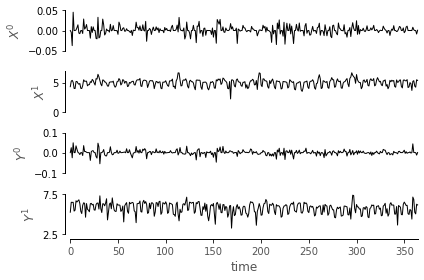

In [8]:
tp.plot_timeseries(dataframe_companies); plt.show()

# Partial Correlation

In [9]:
parcorr = ParCorr(significance='analytic')

pcmci = PCMCI(
    dataframe=dataframe_companies, 
    cond_ind_test=parcorr,
    verbosity=1)


##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 28


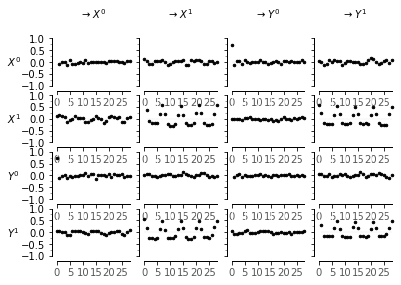

In [10]:
correlations = pcmci.get_lagged_dependencies(tau_max=28, val_only=True)['val_matrix']
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, 
                                    setup_args={'var_names':var_names_companies, 
                                    'x_base':5, 'y_base':.5}); plt.show()

In [11]:
results = pcmci.run_pcmci(tau_max=8, pc_alpha=0.5)
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 8
pc_alpha = [0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $X^0$ has 11 link(s):
        ($Y^0$ -1): max_pval = 0.01107, min_val = -0.136
        ($X^0$ -4): max_pval = 0.07051, min_val = -0.097
        ($X^1$ -1): max_pval = 0.12493, min_val =  0.083
        ($X^1$ -7): max_pval = 0.12716, min_val =  0.082
        ($X^0$ -7): max_pval = 0.14729, min_val = -0.078
        ($Y^1$ -5): max_pval = 0.28045, min_val = -0.058
        ($X^0$ -8): max_pval = 0.31225, min_val = -0.055
        ($X^0$ -6): max_pval = 0.35270, min_val = -0.050
        ($X^1$ -4): max_pval = 0.38909, min_val = -0.047
        ($X^0$ -2): max_pval = 0.40695, min_val = -0.045
        ($X^0$ -5): max_pval = 0.48350, min_val =  0.038

    Variable $X^1$ has 8 link(s):
        ($X^1$ -7): max_pval = 0.00000, min_val =  0.345
        ($X^1$ -1): ma

In [12]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], 
                                        tau_max=8, fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable $X^0$ has 1 link(s):
        ($Y^0$  0): pval = 0.00000 | qval = 0.00000 | val =  0.737

    Variable $X^1$ has 3 link(s):
        ($X^1$ -1): pval = 0.00000 | qval = 0.00000 | val =  0.366
        ($Y^1$  0): pval = 0.00000 | qval = 0.00000 | val =  0.314
        ($X^1$ -7): pval = 0.00000 | qval = 0.00024 | val =  0.250

    Variable $Y^0$ has 1 link(s):
        ($X^0$  0): pval = 0.00000 | qval = 0.00000 | val =  0.737

    Variable $Y^1$ has 3 link(s):
        ($X^1$  0): pval = 0.00000 | qval = 0.00000 | val =  0.314
        ($X^1$ -7): pval = 0.00001 | qval = 0.00027 | val =  0.245
        ($Y^1$ -1): pval = 0.00016 | qval = 0.00524 | val =  0.205


In [13]:
link_matrix = pcmci.return_significant_links(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']

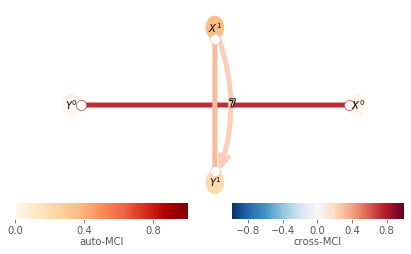

In [14]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names_companies,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    ); plt.show()

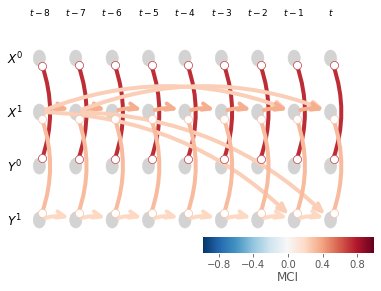

In [15]:
# Plot time series graph    
tp.plot_time_series_graph(
    figsize=(6, 4),
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names_companies,
    link_colorbar_label='MCI',
    ); plt.show()

# GPDC

In [16]:
gpdc = GPDC(significance='analytic', gp_params=None)
pcmci_gpdc = PCMCI(
    dataframe=dataframe_companies, 
    cond_ind_test=gpdc,
    verbosity=0)

In [17]:
results = pcmci_gpdc.run_pcmci(tau_max=8, pc_alpha=0.5)
pcmci_gpdc.print_significant_links(
        p_matrix = results['p_matrix'], 
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)



## Significant links at alpha = 0.01:

    Variable $X^0$ has 6 link(s):
        ($Y^0$  0): pval = 0.00000 | val =  0.569
        ($X^1$  0): pval = 0.00000 | val =  0.177
        ($X^1$ -7): pval = 0.00000 | val =  0.177
        ($Y^1$  0): pval = 0.00000 | val =  0.176
        ($Y^0$ -7): pval = 0.00500 | val =  0.159
        ($X^0$ -6): pval = 0.00900 | val =  0.152

    Variable $X^1$ has 6 link(s):
        ($X^1$ -1): pval = 0.00000 | val =  0.433
        ($Y^1$  0): pval = 0.00000 | val =  0.388
        ($X^1$ -7): pval = 0.00000 | val =  0.328
        ($X^1$ -8): pval = 0.00000 | val =  0.197
        ($X^0$  0): pval = 0.00000 | val =  0.177
        ($Y^0$  0): pval = 0.00300 | val =  0.167

    Variable $Y^0$ has 7 link(s):
        ($X^0$  0): pval = 0.00000 | val =  0.569
        ($Y^1$  0): pval = 0.00000 | val =  0.213
        ($Y^1$ -7): pval = 0.00000 | val =  0.182
        ($Y^0$ -7): pval = 0.00100 | val =  0.172
        ($X^1$  0): pval = 0.00300 | val =  0.167
      

In [18]:
q_matrix = pcmci_gpdc.get_corrected_pvalues(p_matrix=results['p_matrix'], 
                                            tau_max=8, fdr_method='fdr_bh')
pcmci_gpdc.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,  
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable $X^0$ has 4 link(s):
        ($Y^0$  0): pval = 0.00000 | qval = 0.00000 | val =  0.569
        ($X^1$  0): pval = 0.00000 | qval = 0.00000 | val =  0.177
        ($X^1$ -7): pval = 0.00000 | qval = 0.00000 | val =  0.177
        ($Y^1$  0): pval = 0.00000 | qval = 0.00000 | val =  0.176

    Variable $X^1$ has 6 link(s):
        ($X^1$ -1): pval = 0.00000 | qval = 0.00000 | val =  0.433
        ($Y^1$  0): pval = 0.00000 | qval = 0.00000 | val =  0.388
        ($X^1$ -7): pval = 0.00000 | qval = 0.00000 | val =  0.328
        ($X^1$ -8): pval = 0.00000 | qval = 0.00000 | val =  0.197
        ($X^0$  0): pval = 0.00000 | qval = 0.00000 | val =  0.177
        ($Y^0$  0): pval = 0.00300 | qval = 0.00300 | val =  0.167

    Variable $Y^0$ has 4 link(s):
        ($X^0$  0): pval = 0.00000 | qval = 0.00000 | val =  0.569
        ($Y^1$  0): pval = 0.00000 | qval = 0.00000 | val =  0.213
        ($Y^1$ -7): pval = 0.00000 | qval = 0.00000 

In [19]:
link_matrix = pcmci_gpdc.return_significant_links(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']

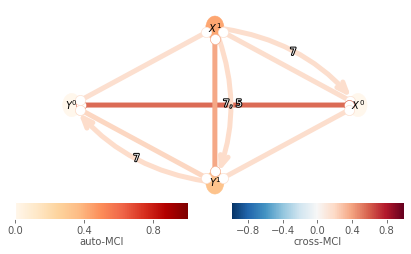

In [20]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names_companies,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    ); plt.show()

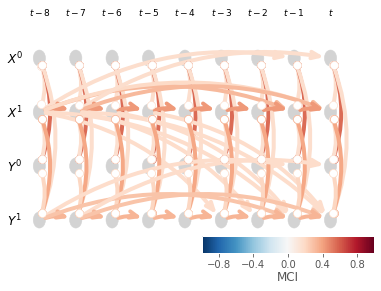

In [21]:
# Plot time series graph    
tp.plot_time_series_graph(
    figsize=(6, 4),
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names_companies,
    link_colorbar_label='MCI',
    ); plt.show()